In [1]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys
import os
import random

# --- PyTorch and Sklearn Imports --
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm

# --- TensorFlow for Data Loading ONLY --
import tensorflow as tf

# --- CRITICAL FIX v2: Isolate TensorFlow to CPU without hiding the GPU from PyTorch ---
try:
    physical_devices = tf.config.list_physical_devices()
    cpus = [d for d in physical_devices if d.device_type == 'CPU']
    tf.config.set_visible_devices(cpus)
    print("✅ TensorFlow successfully configured to use CPU only.")

    # --- VERIFICATION STEP --
    if not tf.config.list_physical_devices('GPU'):
        print("   - Confirmed: TensorFlow does not see the GPU.")
    else:
        print("   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.")

    if torch.cuda.is_available():
        print("✅ PyTorch can see and use the GPU.")
        print(f"   - GPU Device Name: {torch.cuda.get_device_name(0)}")
    else:
        print("   - ❌ CRITICAL WARNING: PyTorch cannot see the GPU. Training will be on CPU.")

except Exception as e:
    print(f"An error occurred during device configuration: {e}")


warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory
DATA_DIR = Path("/kaggle/input/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# --- CORRECTED TFRecord PARSING FUNCTION --
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    """
    feature_description = {}

    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]

    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)

    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

print("\n✅ Setup complete!")







2025-10-11 16:52:02.661270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760201522.851324     109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760201522.904625     109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ TensorFlow successfully configured to use CPU only.
   - ⚠️ WARNING: TensorFlow can still see the GPU. Conflicts may occur.
✅ PyTorch can see and use the GPU.
   - GPU Device Name: Tesla P100-PCIE-16GB
📁 Data directory: /kaggle/input/ndws_western_dataset
📂 Directory exists: True

✅ Setup complete!


In [2]:
# --- UPDATED VISUALIZATION AND RESULTS FUNCTIONS ---

def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4, save_path=None):
    """
    Visualize fire prediction results and optionally save the plot to a file.
    """
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]

    with torch.no_grad():
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()

    if save_path:
        try:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"✅ Visualization saved to '{save_path}'")
        except Exception as e:
            print(f"⚠️ Could not save visualization. Error: {e}")

    plt.show()

    stats = {
        "true_fire_pixels": np.sum(y_test_subset > 0.1),
        "predicted_fire_pixels": np.sum(predictions > 0.5),
        "average_prediction_confidence": np.mean(predictions)
    }

    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {stats['true_fire_pixels']}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {stats['predicted_fire_pixels']}")
    print(f"📈 Average prediction confidence: {stats['average_prediction_confidence']:.4f}")

    return stats

def save_results_to_file(model_name, cv_results, viz_stats, file_path="model_results.txt"):
    """
    Saves the cross-validation and visualization statistics for a model to a text file.
    """
    mean_ap = np.mean(cv_results)
    std_ap = np.std(cv_results)

    try:
        with open(file_path, 'a') as f:
            f.write("="*70 + "\n")
            f.write(f"MODEL: {model_name}\n")
            f.write("="*70 + "\n\n")
            f.write("--- Cross-Validation Summary ---\n")
            f.write(f"Mean Average Precision (AP): {mean_ap:.4f} ± {std_ap:.4f}\n")
            f.write(f"Individual Fold AP Scores: {[f'{score:.4f}' for score in cv_results]}\n\n")
            if viz_stats:
                f.write("--- Visualization Sample Statistics ---\n")
                f.write(f"True Fire Pixels: {viz_stats['true_fire_pixels']}\n")
                f.write(f"Predicted Fire Pixels (>0.5): {viz_stats['predicted_fire_pixels']}\n")
                f.write(f"Average Prediction Confidence: {viz_stats['average_prediction_confidence']:.4f}\n\n\n")
        print(f"✅ Results for '{model_name}' appended to '{file_path}'")
    except Exception as e:
        print(f"⚠️ Could not save results to file. Error: {e}")

print("✅ Visualization and results-saving functions are ready!")

✅ Visualization and results-saving functions are ready!


# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH U-NET ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 23 environmental features** as spatial inputs
- ✅ **U-Net architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The engineered features above are for EDA/visualization only. All prediction uses RAW SPATIAL DATA.

In [3]:
# --- FINAL DATA PROCESSOR: COMBINING TIME-SERIES AND CURRENT DAY DATA ---

class CombinedFireDataProcessor:
    """
    Processes data to give the model the best of both worlds:
    - Historical environmental context (from the past)
    - Current day fire and environmental state
    """
    def __init__(self, data_dir=DATA_DIR, num_timesteps=4):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps # Past days of environmental data
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
            'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
            'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
            'fuel1', 'fuel2', 'fuel3'
        ]

    def load_raw_spatial_data(self, max_sequences=None):
        """
        Load and create the ultimate time-series sequences.
        Input X: viirs_PrevFireMask(t) + Env Features(t-4 to t-1) + Env Features(t)
        Target Y: viirs_FireMask(t+1)
        """
        print("🔥 Loading RAW SPATIAL DATA for COMBINED (Time-Series + Current Day) prediction...")

        tfrecord_files = list(self.data_dir.glob("*.tfrecord"))
        if not tfrecord_files:
            print("❌ No TFRecord files found!")
            return None, None
        print(f"📁 Found {len(tfrecord_files)} TFRecord files")

        all_samples_flat = []

        # --- CORRECTED MEMORY-EFFICIENT LOADING LOGIC ---
        samples_to_load = float('inf') # Load all if max_sequences is None
        if max_sequences:
            sequence_len = self.num_timesteps + 2
            samples_to_load = max_sequences + sequence_len - 1
            print(f" M Optimizing data loading for max_sequences={max_sequences}. Need to load up to {samples_to_load} samples.")

        # Load daily snapshots, stopping only when enough have been collected
        for file_path in tfrecord_files:
            if len(all_samples_flat) >= samples_to_load:
                break # Stop reading files if we have enough samples

            dataset = tf.data.TFRecordDataset(str(file_path))
            for raw_record in dataset:
                if len(all_samples_flat) >= samples_to_load:
                    break # Stop reading records within a file if we have enough
                try:
                    parsed_sample = parse_tfrecord_flexible(raw_record)
                    sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
                    if 'viirs_PrevFireMask' in sample_data and 'viirs_FireMask' in sample_data:
                        all_samples_flat.append(sample_data)
                except Exception as e:
                    print(f"❗️ FAILED TO PROCESS A RECORD in {file_path.name}. Error: {e}")

        print(f"  ...Loaded {len(all_samples_flat)} total individual samples.")

        if not all_samples_flat:
             print("❌ No valid samples were loaded.")
             return None, None

        # --- COMBINED SLIDING WINDOW LOGIC (Unchanged) ---
        spatial_inputs, spatial_targets = [], []
        sequence_len = self.num_timesteps + 2

        for i in range(len(all_samples_flat) - sequence_len + 1):
            if max_sequences and len(spatial_inputs) >= max_sequences:
                break

            past_environmental_sequence = all_samples_flat[i : i + self.num_timesteps]
            current_day_sample = all_samples_flat[i + self.num_timesteps]
            next_day_sample = all_samples_flat[i + self.num_timesteps + 1]

            input_features = []
            input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))
            for past_sample in past_environmental_sequence:
                for feature_name in self.environmental_features:
                    if feature_name in past_sample:
                        input_features.append(past_sample[feature_name].reshape(64, 64, 1))
            for feature_name in self.environmental_features:
                 if feature_name in current_day_sample:
                    input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

            target_mask = next_day_sample['viirs_FireMask'].reshape(64, 64, 1)

            if len(input_features) > 1:
                spatial_inputs.append(np.concatenate(input_features, axis=2))
                spatial_targets.append(target_mask)

        if not spatial_inputs:
            print("❌ Could not create any sequences with the combined logic!")
            return None, None

        X_spatial = np.array(spatial_inputs, dtype=np.float32)
        y_spatial = np.array(spatial_targets, dtype=np.float32)

        print(f"\n✅ COMBINED DATA LOADING COMPLETE")
        print(f"📊 Spatial Input Shape: {X_spatial.shape}")
        print(f"📊 Spatial Target Shape: {y_spatial.shape}")
        return X_spatial, y_spatial

In [4]:
# --- DATASET CLASS AND NORMALIZATION ---
class WildfireDataset(Dataset):
    """
    PyTorch Dataset for loading wildfire sequences "just-in-time" from TFRecords.
    """
    def __init__(self, data_dir, num_timesteps=4, max_sequences=None, normalization_stats=None):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps
        self.normalization_stats = normalization_stats
        self.sequence_len = self.num_timesteps + 2

        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population', 'impervious', 'water',
            'tmp_day', 'tmp_75', 'wind_avg', 'wind_75', 'wdir_wind', 'wdir_gust', 'gust_med',
            'avg_sph', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3'
        ]

        print("🔥 Initializing WildfireDataset: Building sequence index...")
        self.tfrecord_files = sorted(list(self.data_dir.glob("*.tfrecord")))
        self.index = self._build_index()

        if max_sequences is not None and max_sequences < len(self.index):
            print(f"  -- Randomly sampling {max_sequences} sequences from the full dataset.")
            self.index = random.sample(self.index, max_sequences)

        print(f"✅ Index created. Dataset contains {len(self.index)} sequences.")

    def _build_index(self):
        index = []
        for file_path in self.tfrecord_files:
            num_records = sum(1 for _ in tf.data.TFRecordDataset(str(file_path)))
            for i in range(num_records - self.sequence_len + 1):
                index.append((str(file_path), i))
        return index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_path, record_offset = self.index[idx]
        dataset = tf.data.TFRecordDataset(file_path)
        raw_records = dataset.skip(record_offset).take(self.sequence_len)

        daily_samples = []
        for raw_record in raw_records:
            parsed_sample = parse_tfrecord_flexible(raw_record)
            sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
            daily_samples.append(sample_data)

        past_environmental_sequence = daily_samples[0 : self.num_timesteps]
        current_day_sample = daily_samples[self.num_timesteps]
        next_day_sample = daily_samples[self.num_timesteps + 1]

        input_features = []
        input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))
        for past_sample in past_environmental_sequence:
            for feature_name in self.environmental_features:
                if feature_name in past_sample:
                    input_features.append(past_sample[feature_name].reshape(64, 64, 1))
        for feature_name in self.environmental_features:
             if feature_name in current_day_sample:
                input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

        x = np.concatenate(input_features, axis=2).astype(np.float32)
        x = np.transpose(x, (2, 0, 1))

        y = next_day_sample['viirs_FireMask'].reshape(64, 64, 1).astype(np.float32)
        y = (np.transpose(y, (2, 0, 1)) > 0.1).astype(np.float32)

        x_tensor = torch.from_numpy(x)
        y_tensor = torch.from_numpy(y)

        if self.normalization_stats is not None:
            means = self.normalization_stats['means']
            stds = self.normalization_stats['stds']
            x_tensor = (x_tensor - means) / stds

        return x_tensor, y_tensor

def calculate_normalization_stats(dataset, num_samples=500):
    """Calculates mean and std for normalization on a subset of the data."""
    print(f"📊 Calculating normalization statistics on {num_samples} random samples...")
    num_samples = min(num_samples, len(dataset))
    sampler = SubsetRandomSampler(random.sample(range(len(dataset)), num_samples))
    loader = DataLoader(dataset, batch_size=16, sampler=sampler, num_workers=2)

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for inputs, _ in tqdm(loader, desc="Calculating Stats"):
        channels_sum += torch.mean(inputs, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(inputs**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    std[std == 0] = 1 # Avoid division by zero

    stats = {'means': mean.reshape(-1, 1, 1), 'stds': std.reshape(-1, 1, 1)}
    print("✅ Normalization stats calculated.")
    return stats

In [5]:
# --- PYTORCH ResU-Net ARCHITECTURE, LOSS, AND GENERIC TRAINING FUNCTION ---

# 1. LOSS FUNCTION: BCE + Dice
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

# 2. ResU-Net MODEL DEFINITION (Based on the paper)
class ResBlock(nn.Module):
    """Standard Residual Block."""
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class ResUNet(nn.Module):
    def __init__(self, in_channels, out_channels, filters_base=32):
        super(ResUNet, self).__init__()

        # Encoder
        self.enc1 = ResBlock(in_channels, filters_base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResBlock(filters_base, filters_base * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResBlock(filters_base * 2, filters_base * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResBlock(filters_base * 4, filters_base * 8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ResBlock(filters_base * 8, filters_base * 16)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(filters_base * 16, filters_base * 8, kernel_size=2, stride=2)
        self.dec4 = ResBlock(filters_base * 16, filters_base * 8) # 8 (up) + 8 (skip)
        self.upconv3 = nn.ConvTranspose2d(filters_base * 8, filters_base * 4, kernel_size=2, stride=2)
        self.dec3 = ResBlock(filters_base * 8, filters_base * 4)  # 4 (up) + 4 (skip)
        self.upconv2 = nn.ConvTranspose2d(filters_base * 4, filters_base * 2, kernel_size=2, stride=2)
        self.dec2 = ResBlock(filters_base * 4, filters_base * 2)  # 2 (up) + 2 (skip)
        self.upconv1 = nn.ConvTranspose2d(filters_base * 2, filters_base, kernel_size=2, stride=2)
        self.dec1 = ResBlock(filters_base * 2, filters_base)      # 1 (up) + 1 (skip)

        # Output
        self.out_conv = nn.Conv2d(filters_base, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))

        return torch.sigmoid(self.out_conv(d1))

# 3. GENERIC TRAINING FUNCTION
def train_fire_model_cv_pytorch(dataset, model_class, model_args, n_splits=5, epochs=20, batch_size=4, checkpoint_path="model_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_gpu = torch.cuda.is_available()
    print(f"🚀 INITIATING TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None
    start_fold = 0
    checkpoint = None

    if os.path.exists(checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            start_fold = checkpoint.get('fold', 0)
            if checkpoint.get('epoch', -1) == epochs - 1: start_fold += 1
            fold_ap_scores = checkpoint.get('fold_ap_scores', [])
            if start_fold > 0 and start_fold < n_splits:
                print(f"🔄 Resuming training from fold {start_fold + 1}")
        except Exception as e:
            print(f"⚠️ Could not load checkpoint: {e}. Starting from scratch.")
            checkpoint = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        if fold < start_fold: continue

        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=use_gpu)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2, pin_memory=use_gpu)

        model = model_class(**model_args).to(device)
        criterion = BCEDiceLoss(weight=0.2)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        start_epoch = 0
        if checkpoint is not None and fold == checkpoint.get('fold', -1):
            try:
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint.get('epoch', 0) + 1
                if start_epoch < epochs:
                    print(f"🔄 Resuming fold {fold+1} from epoch {start_epoch + 1}")
            except Exception as e:
                print(f"⚠️ Could not load state dicts from checkpoint: {e}. Starting fold from scratch.")
                start_epoch = 0

        print(f"🔥 STARTING TRAINING...")
        for epoch in range(start_epoch, epochs):
            model.train()
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
                loss.backward(); optimizer.step()
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")

            torch.save({'fold': fold, 'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'fold_ap_scores': fold_ap_scores}, checkpoint_path)

        model.eval(); all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.cpu().numpy().flatten())
        
        if len(np.concatenate(all_labels)) > 0 and len(np.unique(np.concatenate(all_labels))) > 1:
            ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
            if len(fold_ap_scores) <= fold: fold_ap_scores.append(ap_score)
            else: fold_ap_scores[fold] = ap_score
            print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        else:
            print(f"⚠️ Fold {fold + 1} Validation - Could not compute AP. Not enough class diversity in labels.")

        last_model = model
        checkpoint = None 

    print("\n\n📊 CROSS-VALIDATION SUMMARY"); print("=" * 60)
    if fold_ap_scores: print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    if last_model:
        model_save_path = f"final_{model.__class__.__name__.lower()}.pth"
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from last fold saved to '{model_save_path}'")
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)
            print(f"🗑️ Removed temporary checkpoint file: '{checkpoint_path}'")

    return last_model, fold_ap_scores

🔥 Initializing WildfireDataset: Building sequence index...
  -- Randomly sampling 1 sequences from the full dataset.
✅ Index created. Dataset contains 1 sequences.
✅ Model configured: ResUNet_Paper with 106 input channels.

--- Step 1: Preparing Dataset ---
🔥 Initializing WildfireDataset: Building sequence index...
  -- Randomly sampling 100 sequences from the full dataset.
✅ Index created. Dataset contains 100 sequences.
📊 Calculating normalization statistics on 100 random samples...


Calculating Stats:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Normalization stats calculated.
🔥 Initializing WildfireDataset: Building sequence index...
  -- Randomly sampling 100 sequences from the full dataset.
✅ Index created. Dataset contains 100 sequences.

--- Step 2: Training ResUNet_Paper ---
🚀 INITIATING TRAINING ON cuda WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)

========== FOLD 1/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 1 Validation - AP: 0.0714

========== FOLD 2/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 2 Validation - AP: 0.0729

========== FOLD 3/3 ==========
🔥 STARTING TRAINING...


Epoch 1/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/25:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/25:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 3 Validation - AP: 0.0462


📊 CROSS-VALIDATION SUMMARY
  - Mean AP ± Std Dev: 0.0635 ± 0.0122

💾 Final model from last fold saved to 'final_resunet.pth'
🗑️ Removed temporary checkpoint file: 'resunet_checkpoint.pth'

🎉 ResUNet_Paper TRAINING COMPLETED!

--- Step 3: Generating Visualizations and Saving Results for ResUNet_Paper ---

✅ Visualization saved to 'resunet_predictions.png'


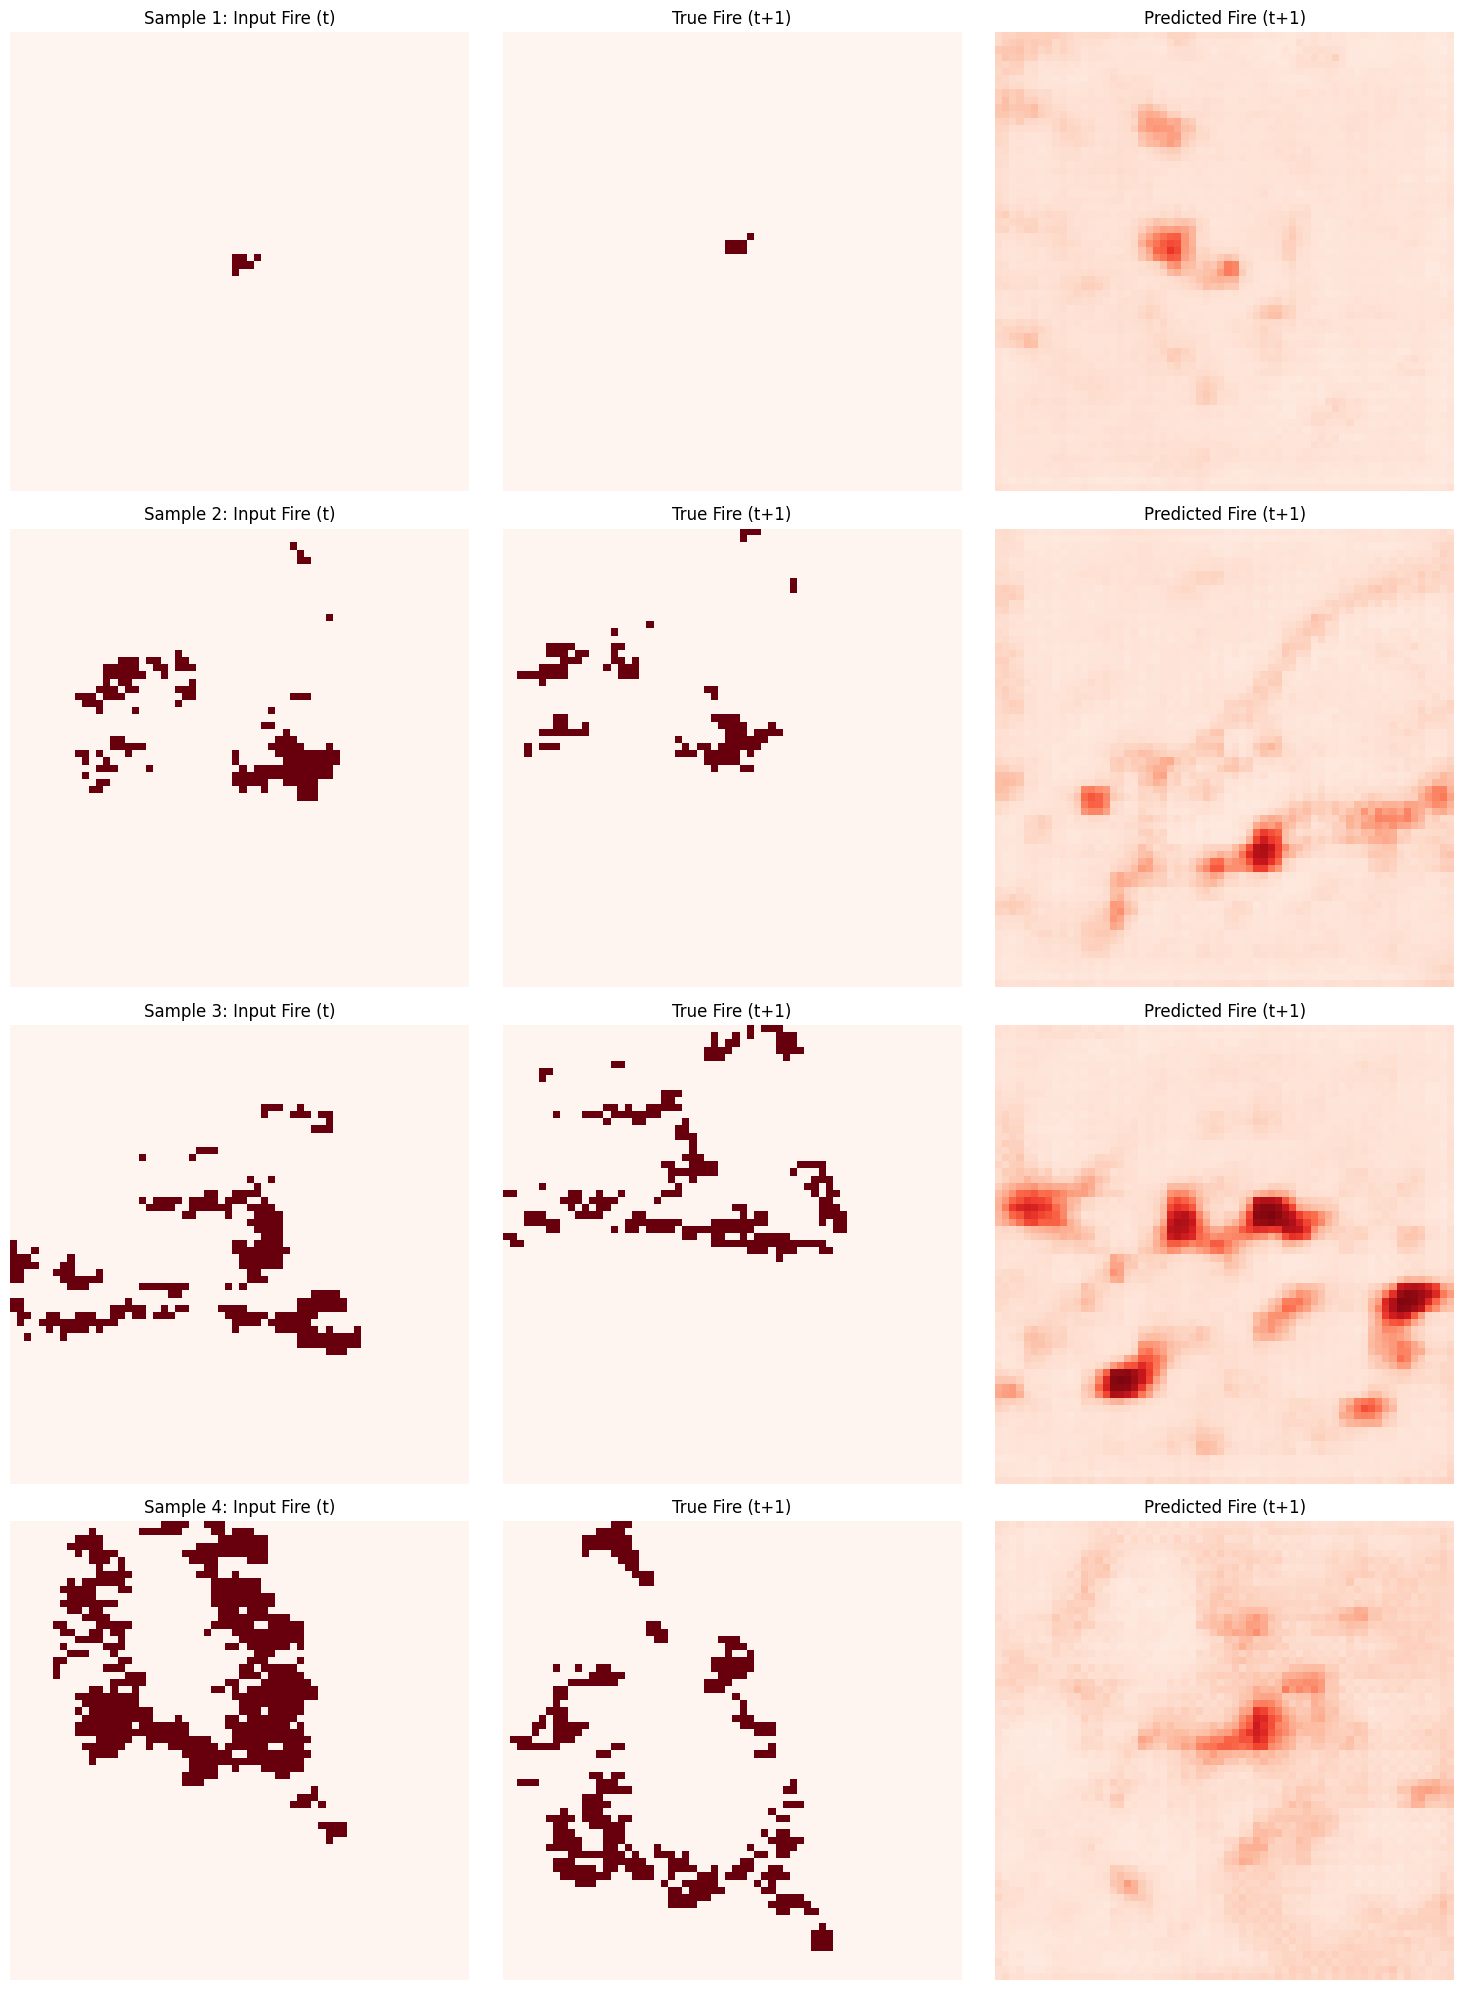


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 713
🎯 Predicted fire pixels (threshold > 0.5): 236
📈 Average prediction confidence: 0.1376
✅ Results for 'ResUNet_Paper' appended to 'model_results.txt'


In [6]:
# --- EXECUTION FOR THE COMBINED TIME-SERIES MODEL WITH RESUNET ---

# --- MODEL CONFIGURATION --
model_name = "ResUNet_Paper"
checkpoint_file = "resunet_checkpoint.pth"

# Get the number of input channels from a sample item
sample_x, _ = WildfireDataset(data_dir=DATA_DIR, max_sequences=1)[0]
num_input_channels = sample_x.shape[0]

# Define the arguments for the ResUNet model
model_args = {
    'in_channels': num_input_channels,
    'out_channels': 1,
    'filters_base': 32
}
print(f"✅ Model configured: {model_name} with {num_input_channels} input channels.")


# 1. Initialize the Dataset (without loading all data into RAM)
print("\n--- Step 1: Preparing Dataset ---")
temp_dataset = WildfireDataset(data_dir=DATA_DIR, num_timesteps=4, max_sequences=100)
normalization_stats = calculate_normalization_stats(temp_dataset, num_samples=100)

full_dataset = WildfireDataset(
    data_dir=DATA_DIR,
    num_timesteps=4,
    max_sequences=100,
    normalization_stats=normalization_stats
)

# 2. Train the ResU-Net model
final_model_resunet = None
cv_results_resunet = []
viz_stats_resunet = None

if len(full_dataset) > 0:
    print(f"\n--- Step 2: Training {model_name} ---")

    final_model_resunet, cv_results_resunet = train_fire_model_cv_pytorch(
        dataset=full_dataset,
        model_class=ResUNet, # Use the new ResUNet class
        model_args=model_args,
        n_splits=3,
        epochs=25,
        batch_size=4,
        checkpoint_path=checkpoint_file
    )

    if cv_results_resunet:
        print(f"\n🎉 {model_name} TRAINING COMPLETED!")
    else:
        print(f"❌ {model_name} training failed or was interrupted!")
else:
    print(f"❌ Cannot train model - dataset is empty!")

# 3. Visualization and Saving Results
if final_model_resunet is not None:
    print(f"\n--- Step 3: Generating Visualizations and Saving Results for {model_name} ---\n")

    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    _, val_indices = list(kfold.split(full_dataset))[-1]

    num_viz_samples = min(4, len(val_indices))
    if num_viz_samples > 0:
        viz_inputs, viz_targets = [], []
        for i in range(num_viz_samples):
            x, y = full_dataset[val_indices[i]]
            viz_inputs.append(np.transpose(x.numpy(), (1, 2, 0))) # H, W, C
            viz_targets.append(np.transpose(y.numpy(), (1, 2, 0)))

        X_test_norm = np.array(viz_inputs)
        y_test_binary = np.array(viz_targets)

        # The visualization function now needs the normalized data
        viz_stats_resunet = visualize_fire_predictions_pytorch(
            final_model_resunet, X_test_norm, y_test_binary, num_samples=num_viz_samples, save_path="resunet_predictions.png"
        )
        
        save_results_to_file(model_name, cv_results_resunet, viz_stats_resunet)

    else:
        print("Not enough validation samples to visualize.")

else:
    print(f"\n⚠️ {model_name} model not available for evaluation.")